# Training a Formula 1 Strategist using Deep Reinforcement Learning

## Introduction

In Formula 1, races are won and lost depending on the pit stop strategy that a team uses for a grand prix. We don't need to look any further than the latest Formula 1 race at the 2021 Spanish Grand Prix to see how important it is to have the best pitstop strategy, where Lewis Hamilton and his Mercedes team outsmarted Max Verstappen and the Red Bull Racing team to take first place[5]. In this project, we train an agent to decide when in a race to make pitstops, and which tires change to, using a Double-Deep Q-Network. We also employ other techniques which have been shown to improve the performance of reinforcement learning algorithms, such as experience replay. 

Double-Deep Q Networks were introduced by [1] the team at DeepMind as part of their Atari game agents, where they extended the general idea of Double-Q learning in a tabular environment to Deep Q-Learning, which uses function approximation in place of a Q table for action-value estimation. The problem that Double-Q learning solves is one where Q-values in certain environments would over-estimate the values of certain actions, making it more difficult for the agent converge to optimal solutions in a stable fashion. This is due to the fact that the network being trained to learn the Q-values is the same one generating behavior from which the agent learns. The main idea behind Double-Deep Q learning is to create two neural networks, an online network that we update during every training step that generates the actions that the agent takes, and a "target" network that we fix for a number of steps which we use to evaluate the actions that our agent takes. 

The DDQN model update rule is that the TD target $Q^*$ for action $a_t$ in state $s_t$ is given by the following formula:

$Q^*(s_t,a_t) = r_t + \gamma Q(s_{t+1}, argmax_{a'}Q'(s_{t+1},a'))$

In the formula above, $Q'$ represents the fixed target network that is only updated every so often, while $Q$ represents the online policy that we use to select actions during training. As stated, every so often we copy the weights from $Q$ to the target network $Q'$.

To ensure that the algorithm is behaving properly, we start by testing our Double-Deep Q Network (DDQN) implementation in a well known RL environment, cartpole. In cartpole, we see that the DDQN approach can lead to better training performance, but that it can also be sensitive to the hyper-parameters we select, in this case the number of steps that we wait until updating our target network. We then continue on to our custom Formula 1 strategy environment and training an agent using the DDQN approach.



## Code Overview

In this notebook, we've included all of the DDQN-related methods within in the `DDQN` class below. This includes training methods specific to the two environments we are testing, the creation of online and target networks, methods related to experience replay and the memory buffer, and more. In the "formulaone.py" file in this repository, we implement our custom Formula 1 environment. A thorough overview and explanation of the environment is given later.

The `DDQN` class takes the following parameters as inputs when it is initialized.

- `env`: The reinforcement learning environment that the agent will be training in. In our cases, this is either Cartpole or our custom Formula 1 environment.

- `learning_rate`: This is the learning rate used for the neural newtork optimiser. In our cases, we employ the Adam optimiser, as it is generally one of the most widely used in deep learning and deep reinforcement learning. In our cases, we use a learning rate between .0001 and .001.

- `gamma`: Gamme is the discount factor that we apply to rewards in future steps

- `epsilon`: A key part of training reinforcement learning agents is the balance between exploration and exploitation. We use an epsilon-greedy policy, where the epsilon parameter determines how often we take random actions to explore the environment. In our cases, we use a starting epsilon value of between 0.5 and 1.

- `epsilon_decay`: In order to strike a good balance between exploration and exploitation, we decay our epsilon value over time. Every episode, we multiply our latest epsilon value by our epsilon decay rate, for which we generally use a value between .99 and .999. A key assumption needed for convergence in RL algorithms is that our agent never stops some random exploration. For this reason, we maintain a minimum epsilon value of 0.01.

- `num_actions`: The number of potential actions that our agent can take in the given environment. This is used when initiliazing the Q network, where the number of output nodes is equal to the number of actions that our agent can take.

- `num_obs`: This is the size of the observation state that we feed into our Q network. This is also used for the initialization of the neural network to define the input dimensions.

- `double_Q`: This is a boolean parameter that determines whether or not we employ the double-Q algorithm. If it is set to true, we create both an online and target network, and employ the double-Q algorithm when training the agent. If the parameter is set to false, we implement a classic DQN algorithm without a fixed target network.

- `target_update_steps`: When we do use the DDQN implementation, this parameter determines how often we update our target network with the weights of the online network. In this implementation, we do a hard network update, where we simply copy the weights of the online network to the target network. Some implementations also use a soft update, where rather than copying the weights of the online network every so many steps, weights of the target network are updated slowly in the direction of the online network every step.

- `min_replay_size`: As part of the experience replay methodology, before training begins we fill the memory buffer with experience from randomly generated actions within the environment. This parameter determines how many samples of past experience we generate before beginning the training of our agent. 

Network Architecture: Although it is not a parameter, the architecture that we use for the online and target networks are that of a shallow neural network with only one hidden layer of 200 nodes, which uses a ReLu activation function. We use the mean squared error as the loss metric, and again use the Adam optimiser for the neural network. 

Experience Replay: Experience replay was also introduced by the DeepMind team in their Atari paper. [1]
A fundamental requirement for convergence in RL trainin is that the training data is independent and identically distributed. However, when our agent interacts with the environment, the sequence of experiences can be highly correlated. The naive Q-learning algorithm that learns from each of these experiences in sequential order one at a time runs the risk of getting swayed by the effects of this correlation. Experience replay solves this problem by storing a large memory of past experiences, and at every step it samples a random batch of past experiences to update network. In addition to minimizing harmful correlations, experience replay allows us to learn more from individual experiences multiple times, recall rare occurrences, and in general make better use of our experience.



In [2]:
import sys
sys.path.insert(1,'formulaone/formulaone/envs')
import formulaone_env
from formulaone_env import FormulaOne

import numpy as np
import matplotlib.pyplot as plt



In [3]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random


from keras import Sequential
from keras import Input
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model


import pickle
from matplotlib import pyplot as plt


class DDQN:

    def __init__(self, env, lr, gamma, epsilon, epsilon_decay,num_actions,num_obs,doubleQ = False,target_update_steps=1,min_replay_size = 1000):

        self.env = env
        self.doubleQ = doubleQ
        self.min_replay_size = min_replay_size

        
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=20000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        
        self.num_action_space = num_actions
        self.num_observation_space = num_obs
       
        
        self.online_model = self.initialize_model()
        #if we make doubleQ model, initialize target network as well
        if doubleQ:
            self.target_model = self.initialize_model()
        self.steps_per_target_update = target_update_steps

    def initialize_model(self):
        #shallow network with 200 nodes
        model = Sequential()
        model.add(Input(shape=(self.num_observation_space,)))
        model.add(Dense(200, activation=relu))
        
        model.add(Dense(self.num_action_space, activation=linear))

        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.get_random_action()
        
        predicted_actions = self.online_model.predict(state)
        return np.argmax(predicted_actions[0])

    def get_random_action(self):
        return random.randrange(self.num_action_space)

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))
    
    def fill_memory_buffer_cartpole(self):
        #method for filling the memory buffer for cartpole env
        while len(self.replay_memory_buffer) < self.min_replay_size:
            state = env.reset()
            state = np.reshape(state, [1, self.num_observation_space])
            step = 0
            for step in range(200):
                action = self.get_random_action()
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                if len(self.replay_memory_buffer) >= self.min_replay_size:
                    break
                self.add_to_replay_memory(state, action, reward, next_state, done)
                state = next_state               
                if done:
                    break


    def fill_memory_buffer_f1(self):
        #method for filling replay buffer for f1 environment
        min_laps = 30
        max_laps = 60
        while len(self.replay_memory_buffer) < self.min_replay_size:
            laps = random.randint(min_laps,max_laps)
            full_state = env.reset(laps)
            #get observed state for driver 1
            state = env.get_racer_1_obs(full_state)
            state = np.reshape(state, [1, self.num_observation_space])
            done = False
            a2 = 0
            while not done:
                received_action = self.get_random_action()   
                #our env needs multiple actions
                actions = [received_action,a2]
                next_full_state, rewards, done, info = env.multi_step(actions)
                reward = rewards[0]
                next_state = env.get_racer_1_obs(next_full_state)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                
                if laps - next_full_state[0][2]==15:
                    a2 = 3
                else:
                    a2 = 0
                
                if done:
                    if env.get_racer_1_obs_interval(next_full_state)[9] == 0:
                        reward-= 10000

                if len(self.replay_memory_buffer) >= self.min_replay_size:
                    break
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                state = next_state
                if done:
                    break
    
    def fill_memory_buffer_f1_interval(self):
        #method for filling replay buffer for f1 environment
        min_laps = 30
        max_laps = 60
        while len(self.replay_memory_buffer) < self.min_replay_size:
            laps = random.randint(min_laps,max_laps)
            full_state = env.reset(laps)
            #get observed state for driver 1
            state = env.get_racer_1_obs(full_state)
            state = np.reshape(state, [1, self.num_observation_space])
            done = False
            a2 = 0
            while not done:
                received_action = self.get_random_action()   
                #our env needs multiple actions
                actions = [received_action,a2]
                next_full_state, rewards, done, info = env.multi_step(actions)
                next_state = env.get_racer_1_obs(next_full_state)
                reward = rewards[0]
                
                if laps - next_full_state[0][2]==15:
                    a2 = 3
                else:
                    a2 = 0
                
                if done:
                    if env.get_racer_1_obs_interval(next_full_state)[9] == 0:
                        reward-= 10000
                    elif env.get_racer_1_obs_interval(next_full_state)[8] == 0:
                        reward+= 5*laps
                
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                if len(self.replay_memory_buffer) >= self.min_replay_size:
                    break
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                state = next_state
                if done:
                    break
        

    def update_target(self):
        #copy network weights from online network to target network in doubleQ training
        self.target_model.set_weights(self.online_model.get_weights())
        
    
    def learn_and_update_weights_by_reply(self):
        
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attributes_from_sample(random_sample)
        # update target network if necessary
        if self.doubleQ:
            #if using doubleQ learning, use target network for target Q values
            if self.counter%self.steps_per_target_update == 0:
                        self.update_target()
            targets = rewards + self.gamma * (np.amax(self.target_model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
            target_vec = self.target_model.predict_on_batch(states)
        else:
            #if using standard Q learning, use the online model to generate target Q values
            targets = rewards + self.gamma * (np.amax(self.online_model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
            target_vec = self.online_model.predict_on_batch(states)
        
        
        indexes = np.array([i for i in range(self.batch_size)])
        #update only the target values for the actions we took
        target_vec[[indexes], [actions]] = targets
        self.online_model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attributes_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train_cartpole(self,num_episodes = 500):
        # method for taining specifically in the cartpole environment
        max_steps_per_episode = 200

        for episode in range(num_episodes):
            state = env.reset()
            state = np.reshape(state, [1, self.num_observation_space])
            reward_for_episode = 0
            for _ in range(max_steps_per_episode):
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                self.add_to_replay_memory(state, action, reward, next_state, done)
                reward_for_episode += reward
                state = next_state
                self.learn_and_update_weights_by_reply()
                self.update_counter()
                if done:
                    break
            self.rewards_list.append(reward_for_episode)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            last_rewards_mean = np.mean(self.rewards_list[-20:])
            print(episode, ": Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",round(last_rewards_mean,2), "\t epsilon: ", round(self.epsilon,2) )
    
    
   
    def train_f1(self, num_episodes=2000):
        #method for training in our custom formula 1 environment

        min_laps = 30
        max_laps = 60
        for episode in range(num_episodes):
            laps = random.randint(min_laps,max_laps)
            full_state = env.reset(laps)
            #get observed state for driver 1
            state = env.get_racer_1_obs(full_state)
            state = np.reshape(state, [1, self.num_observation_space])
            reward_for_episode = 0
            done = False
            a2 = 0
            while not done:
                received_action = self.get_action(state)
                #our env needs multiple actions
                actions = [received_action,a2]
                next_full_state, rewards, done, info = env.multi_step(actions)
                #define some policy for actions for driver 2 to compare
                if laps - next_full_state[0][2]==15:
                    a2 = 3
                else:
                    a2 = 0
                next_state = env.get_racer_1_obs(next_full_state)
                reward = rewards[0]
                reward_for_episode += rewards[0]
                
                if done:
                    #define negative reward if agent hasn't used multiple tire types
                    if env.get_racer_1_obs_interval(next_full_state)[9] == 0:
                        reward-= 10000
                        reward_for_episode = -100 * laps

                next_state = np.reshape(next_state, [1, self.num_observation_space])
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                state = next_state
                self.learn_and_update_weights_by_reply()
                self.update_counter()
                
                if done:
                    break
            
            self.rewards_list.append(reward_for_episode / laps)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if episode%1000 == 0:
                #env.render()   
                print(episode, ": Episode || Reward: ",round(reward_for_episode / laps,2), "\t|| Average Reward: ",round(last_rewards_mean,2), "\t epsilon: ", round(self.epsilon,2) )
            if episode%2500 == 0:   
                plot_race_baseline(laps = 45, agent=self)
              
    
    def update_counter(self):
        self.counter += 1
        


## Training in the Cartpole Environment

Since deep reinforcement learning algorithms are known to be unstable and very difficult to debug and reproduce [4] , we used the simple Cartpole environment to test the implementation of our algorithm and evaluate the effectiveness of the Double Q learning approach. Cartpole is a classic RL environment where the agent has 2 actions, pushing the cart left or right, and its goal is to keep a pole that sits on the cart upright for as long as possible. The observations that the agent makes on the environment can be summarized by 4 values, the cart position, the cart velocity, the pole angle, and the pole angular velocity. Since these observations are continuous values, it's not possible to use a traditional Q table to calculate Q-values, so we need to use function approximation methods for this, in our case a neural network.

In this project, we compare the results of three training approaches in the Cartpole environment. In the first, we simply use DQN, without the double-Q approach of a target network. In the second, we use DDQN and update our target network every 20 steps, and in the final, we use the DDQN approach and update our target network every 100 steps. All other hyper-parameters are the same between the training runs. A discussion of the results is below. 

In [24]:
### CARTPOLE PARAMETERS

env = gym.make('CartPole-v0')

# set seeds
env.seed(21)
np.random.seed(21)
random.seed(21)

lr = 0.001
epsilon = 0.5
epsilon_decay = .99
gamma = .99
training_episodes = 300

In [25]:
#cartpole no double

cp_agent_1 = DDQN(env, lr, gamma, epsilon, epsilon_decay,2,4,doubleQ = False,target_update_steps = 1,min_replay_size = 1000)
cp_agent_1.fill_memory_buffer_cartpole()
cp_agent_1.train_cartpole(training_episodes)



St
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               1000      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
0 	: Episode || Reward:  12.0 	|| Average Reward:  12.0 	 epsilon:  0.49
1 	: Episode || Reward:  11.0 	|| Average Reward:  11.5 	 epsilon:  0.49
2 	: Episode || Reward:  9.0 	|| Average Reward:  10.67 	 epsilon:  0.49
3 	: Episode || Reward:  10.0 	|| Average Reward:  10.5 	 epsilon:  0.48
4 	: Episode || Reward:  9.0 	|| Average Reward:  10.2 	 epsilon:  0.48
5 	: Episode || Reward:  17.0 	|| Average Reward:  11.33 	 epsilon:  0.47
6 	: Episode || Reward:  10.0 	|| Average Reward:  11.14 	 epsilon: 

In [26]:
#cartpole double quick update


cp_agent_2 = DDQN(env, lr, gamma, epsilon, epsilon_decay,2,4,doubleQ = True,target_update_steps = 20,min_replay_size = 1000)
cp_agent_2.fill_memory_buffer_cartpole()
cp_agent_2.train_cartpole(training_episodes)


St
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               1000      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               1000      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
0 	: Episode ||

In [27]:
#cartpole double long update


cp_agent_3 = DDQN(env, lr, gamma, epsilon, epsilon_decay,2,4,doubleQ = True,target_update_steps = 100,min_replay_size = 1000)
cp_agent_3.fill_memory_buffer_cartpole()
cp_agent_3.train_cartpole(training_episodes)

St
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 200)               1000      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               1000      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
0 	: Episode ||

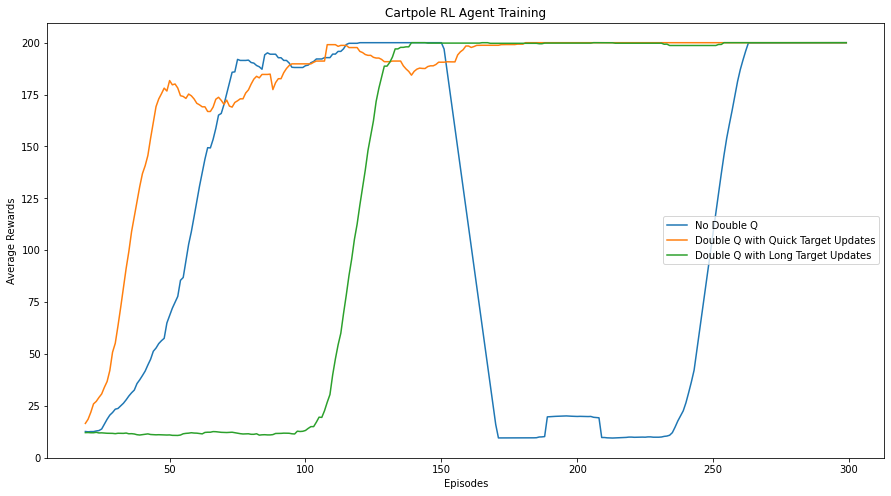

In [28]:
#plotting cartpole results

train_rewards_list_1 = pd.DataFrame(cp_agent_1.rewards_list)
average_rewards_1 = train_rewards_list_1[train_rewards_list_1.columns[0]].rolling(20).mean()

train_rewards_list_2 = pd.DataFrame(cp_agent_2.rewards_list)
average_rewards_2 = train_rewards_list_2[train_rewards_list_2.columns[0]].rolling(20).mean()

train_rewards_list_3 = pd.DataFrame(cp_agent_3.rewards_list)
average_rewards_3 = train_rewards_list_3[train_rewards_list_3.columns[0]].rolling(20).mean()

plt.figure(figsize=(15, 8))
plt.close()
plt.figure()

plot = average_rewards_1.plot(linewidth=1.5, figsize=(15, 8),label = "No Double Q")
plot = average_rewards_2.plot(linewidth=1.5, figsize=(15, 8), label = "Double Q with Quick Target Updates")
plot = average_rewards_3.plot(linewidth=1.5, figsize=(15, 8), label = "Double Q with Long Target Updates")

plt.title("Cartpole RL Agent Training")
plot.set_xlabel("Episodes")
plot.set_ylabel("Average Rewards")
plt.legend()

The graph above displays the results of training using the three different approaches mentioned previously. In blue, we haven't used the double-Q approach with the target network. While our network seems to be able to solve the environment fairly well within the first 100 steps, the stability of the optimal policy is not great, as we see that between 150-250 steps the agent "forgets" how to solve the environment and performs very poorly for a little stretch before re-learning the optimal policy and keeping the pole balanced for the required 200 steps. 

In orange, we implement a DDQN agent where we update the weights of the target network every 20 steps. The agent does seems to be able to learn how to keep the pole upright quicker than our non-DDQN agent, and once it does learn the optimal policy to keep the pole upright, the agent is much more stable than our non-DDQN agent.

In green, we again implement a DDQN agent but this time only update the target network every 100 steps. This longer update time seems to make it harder for the agent to initially learn the optimally policy, but once it does learn to keep the pole upright after around 100 steps it solves the environment remarkably quickly, and also stays stable at the optimal policy.

These test runs in the cartpole environment demonstrate the performance improvements that can be enjoyed by implementing the DDQN algorithm, and gives us confidence that our implementation of the algorithm is working as intended before we test it on more complicated environments where it's harder to evaluate the performance of certain algorithms due the general unstable nature of RL algorithms, expecially in the non-linear function approximation setting where convergence to optimal policies isn't always guaranteed.

## Formula 1 Helper Functions
These next two helper methods are used to plot training performance in the Formula 1 environment, and visualize race simulations that help us evaluate the performance of our trained agents.

In [4]:
def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df['rolling_mean'] = df[df.columns[0]].rolling(50).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    # plt.ylim((-400, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(False)
    plt.ylim(55,70)
    fig.savefig("F1 results")

In [2]:
def plot_race_baseline(laps,agent): 
    env = FormulaOne()
    env.reset(laps)
    total_times_1 = []
    total_times_2 = []
    pitstops_1 = 0
    pitstops_2 = 0
    pitstop_laps_1 = []
    pitstop_laps_2 = []
    tires_1 = [] 
    tires_2 = []
    laps = []
    a1=0
    a2 = 0
    lap = 1
    while True:
        actions = [a1,a2]
        s, r, done, _ = env.multi_step(actions)
        

        state = env.get_racer_1_obs(s)
        state = np.reshape(state, [1, 8])
        a1 = np.argmax(agent.online_model.predict(state))
        if lap == 15:
            a2=3
        else:
            a2=0
    
    
        laps.append(lap)
        racer_1_pos = int(np.where(s[:,1] == 1)[0][0])
        racer_2_pos = int(np.where(s[:,1] == 2)[0][0])

        if s[racer_1_pos][6] == 1:
            pitstop_laps_1.append(lap)
            tires_1.append(s[racer_1_pos][5])
        if s[racer_2_pos][6] == 1:
            pitstop_laps_2.append(lap)
            tires_2.append(s[racer_2_pos][5])

        total_times_1.append(s[racer_1_pos][7]-(55*lap))
        total_times_2.append(s[racer_2_pos][7]-(55*lap))
        if done:
            break
        
    
        lap+=1
    #env.render()
    pitstop_laps_1.append(lap)
    pitstop_laps_2.append(lap)
    plt.rcParams["figure.figsize"] = (15,8)

    stints_1 = len(pitstop_laps_1)
    for i in range(stints_1-1):
        if tires_1[i] == 0:
            c = 'r'
        if tires_1[i] == 1:
            c = 'y'
        if tires_1[i] == 2:
            c = 'k'    
        x = np.arange(max(1,pitstop_laps_1[i]-1),pitstop_laps_1[i+1])
        indices = x
        total_times_1 = np.asarray(total_times_1)
        if i == 0:
            plt.plot(x,total_times_1[indices],linestyle = 'dashed',color = c, label="Agent Racer")
        else:
            plt.plot(x,total_times_1[indices],linestyle = 'dashed',color = c)

    stints_2 = len(pitstop_laps_2)
    for i in range(stints_2-1):
        if tires_2[i] == 0:
            c = 'r'
        if tires_2[i] == 1:
            c = 'y'
        if tires_2[i] == 2:
            c = 'k'    
        x = np.arange(max(1,pitstop_laps_2[i]-1),pitstop_laps_2[i+1])
        indices = x
        total_times_2 = np.asarray(total_times_2)
        if i == 0: 
            plt.plot(x,total_times_2[indices],color = c,label = "Deterministic Racer")
        else:
            plt.plot(x,total_times_2[indices],color = c)
    plt.title("Simulated Race Result")
    plt.xlabel("Laps")
    plt.ylabel("Pace Differential (Relative to an Average Lap Time of 55 Seconds)")
    plt.legend()
    plt.show()



## Training in Formula 1

As mentioned above, we've built a custom game environment to solve the Formula 1 strategy problem. In a Formula 1 race, a team must decide how often to make a pit stop and which tires to put on the car when they do. There are 3 possible tire compounds, the red softs, the yellow mediums, and black hards. The tradeoff that teams have to deal with is that softer tires are faster, but don't last as long. In our environment, we have the base speed of the soft tires to be 1 second per lap faster than the medium tires, which in turn are 1 second per lap faster than the hard tires. All cars start the race on the soft tire in this environment, similar to how most cars in real Formula 1 races generally start on soft tires due to specific qualification rules. 

We define the tire life of the soft tire to be 10 laps, the tire life of the medium tire to be 20 laps, and the tire life of the hard tire to be 40 laps. As the laps done on a specific tire increase, the tires lose grip and get slower. Before a tire gets to the end of it's "life", the performance degradation is relatively minimal, and in our envrionment they only lose a twentieth of a second per lap. However, once a tire has gotten to the end of it's life, degradation can be severe, and teams cannot stay on old tires for too long before losing a lot of time. In our environment, degradation once a tire has reached its "life" becomes exponentially worse the longer they stay on the same set of old tires. Another factor that determines the pace of the car is how much fuel is left in the car. In our environment, we linearly decrease the impact that fuel has on the speed of the car, adding 5 seconds to the lap time at the beginning of the race and adding 0 seconds by the time the race is over. To make it a stochastic environment and mimic the subtle changes from lap to lap that we observe in the real world, we also randomly add between 0 and 0.05 seconds when determining the pace of the agent's car for the ensuing lap.  

An additional rule in place in Formula 1 is that during a race, drivers must use two seperate types of compounds, otherwise their car is disqualified. In order to attempt to incentivise the agent to learn to use multiple types of tires, if our agent finishes a race without using multiple types of tires, we apply a harsh penalty in the form of a significant negative reward at the end of the race.

In terms of how actions and rewards work in this environment, each lap is considered a new step, and agents have 4 possible choices: 0 - do nothing, continue on to the next lap, 1 - make a pit stop and put on soft tires, 2 - make a pit stop and put on medium tires, and finally 3 - make a pit stop and put on hard tires. Note that making a pit stop adds 20 seconds to a lap time, so it is generally beneficial to make relatively few pit stops in a race. Rewards at every step are then definined to simply be the lap time after every lap. We don't discount future rewards, so as to incentivize the agent to minimize the total time it takes to complete a race. As alluded to above, we do make an adjustment to the reward in the case that the agent has not used multiple tire compounds in that race.

When we first started training our agent to learn this Formula 1 strategy game, we fixed the race distance to be 45 laps, an average number of laps in a real Formula 1 race. However, we quickly noticed that it was easy enough for our agent to just memorize at which lap to pit for which tire. Our goal was to build an agent that could perform well in a general Formula 1 strategy environment at any given race, so we changed the fixed number of laps to be randomly selected for every training race, between 30 and 60 laps.  

In deep reinforcement learning, it is incredibly important to select features from the observation space that will allow the agent to understand how the environment works in order to gain the optimal rewards. When building AlphaGo, DeepMind carefully crafted the features that were fed to the neural network, and we took a similar approach here. [2]

In our implementation, the features that our agent learns from are listed below.

- `laps_remaining`: The amount of laps left until the end of the race.
- `pace`: The latest lap time.
- `tire`: Which tire the agent currently has on the car.
- `tire_age`: How many laps the current tire has been on the car.
- `pitsops`: How many pitstops the agent has taken so far.
- `tire_compound_flag`: A boolean flag that indicates whether the agent has used multiple tires types, thus avoiding disqualification.
- `tire_age_flag`: A boolean flag that indicates to the agent whether or not the current tire has exceeded it's life, as indication that lap times will start to exponentially increase if it does not make a pitstop soon.
- `pace_difference`: The difference between the lap time of the current lap and of the previous one, helping the agent understand when it is losing a lot of time.

We decide to train the agent for 15,000 race episodes, taking about 10-12 hours each time. Every 1,000 races we output the latest average reward of the agent. To make rewards across different race lengths comparable, we report the reward as the average lap time during the race, rather than the total time elapsed during the race. Every 2,500 episodes, we test the agent by running a race simulation in a 45 lap race. In these race simulations, we compare the performance of the agent to that of a deterministic racer who's strategy is defined as follows: make one pitstop in the race at lap 15, putting on the hard tires until the end of the race. A further explanation of the simulation graphs is presented below.


In [6]:
## F1 PARAMETERS
env = FormulaOne()

# set seeds
env.seed(21)
np.random.seed(21)
random.seed(21)



lr = 0.0001
epsilon = 1
epsilon_decay = 0.999
gamma = 1
training_episodes = 15000

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 2,604
Trainable params: 2,604
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               1800      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 804       
Total params: 2,604
Trainable params: 2,604
Non-trainable params: 0
_________________________________________________________________
None
0 : Episode || Rewar

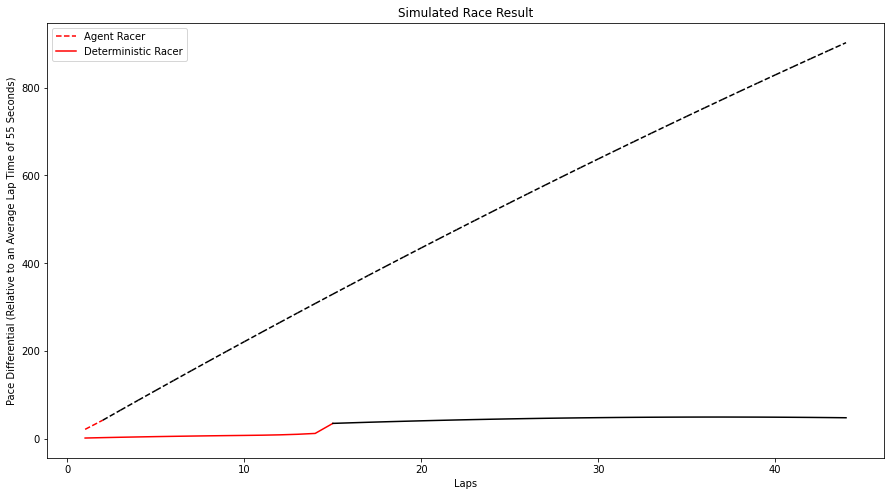

1000 : Episode || Reward:  -60.87 	|| Average Reward:  -60.49 	 epsilon:  0.37
2000 : Episode || Reward:  -59.58 	|| Average Reward:  -58.71 	 epsilon:  0.14


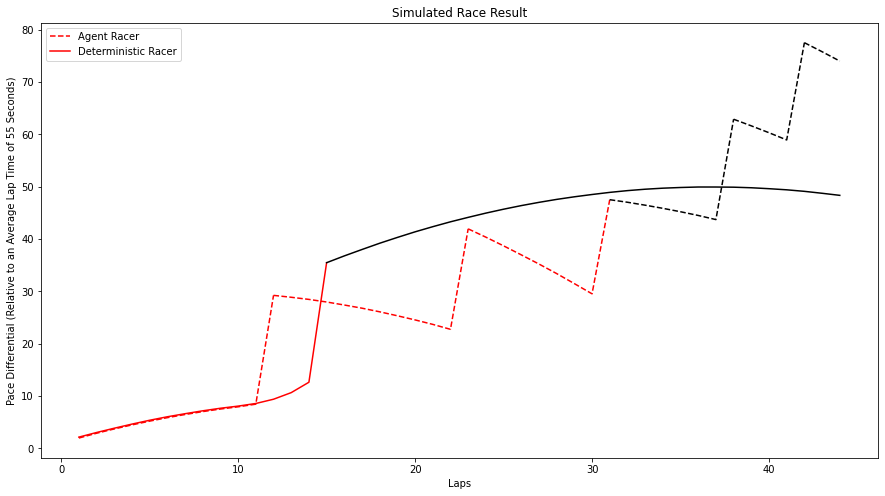

3000 : Episode || Reward:  -56.81 	|| Average Reward:  -56.93 	 epsilon:  0.05
4000 : Episode || Reward:  -55.72 	|| Average Reward:  -56.07 	 epsilon:  0.02
5000 : Episode || Reward:  -56.26 	|| Average Reward:  -55.84 	 epsilon:  0.01


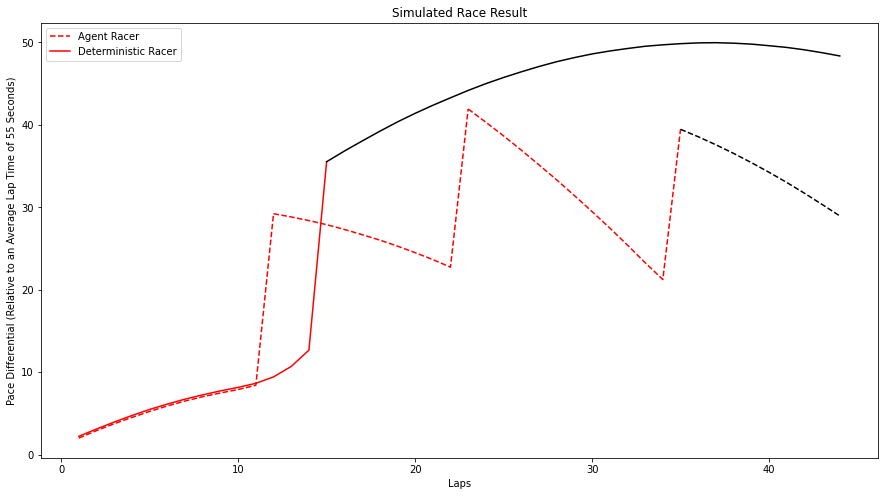

6000 : Episode || Reward:  -56.12 	|| Average Reward:  -55.91 	 epsilon:  0.01
7000 : Episode || Reward:  -56.05 	|| Average Reward:  -55.92 	 epsilon:  0.01


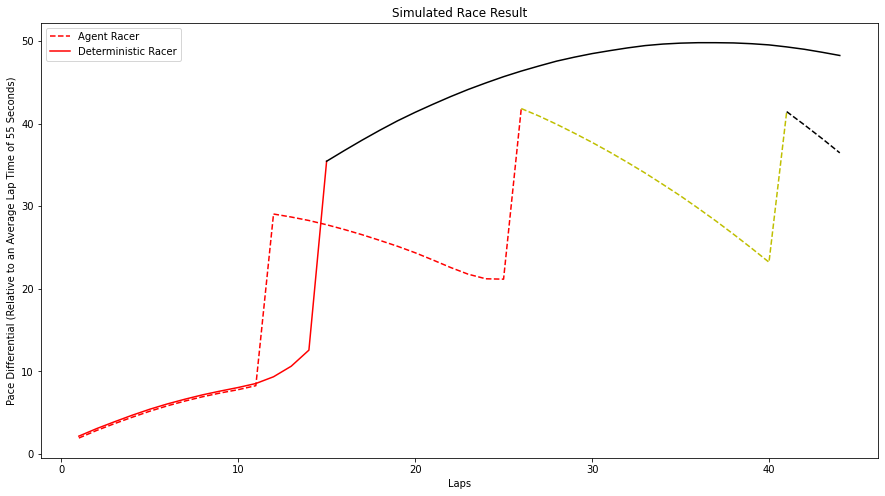

8000 : Episode || Reward:  -55.99 	|| Average Reward:  -56.0 	 epsilon:  0.01
9000 : Episode || Reward:  -55.87 	|| Average Reward:  -56.01 	 epsilon:  0.01
10000 : Episode || Reward:  -56.11 	|| Average Reward:  -55.99 	 epsilon:  0.01


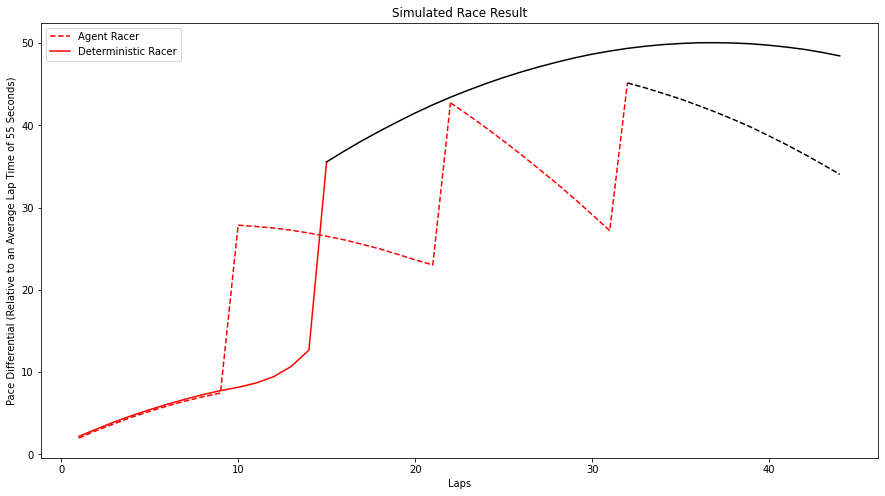

11000 : Episode || Reward:  -56.38 	|| Average Reward:  -56.95 	 epsilon:  0.01
12000 : Episode || Reward:  -56.56 	|| Average Reward:  -56.25 	 epsilon:  0.01


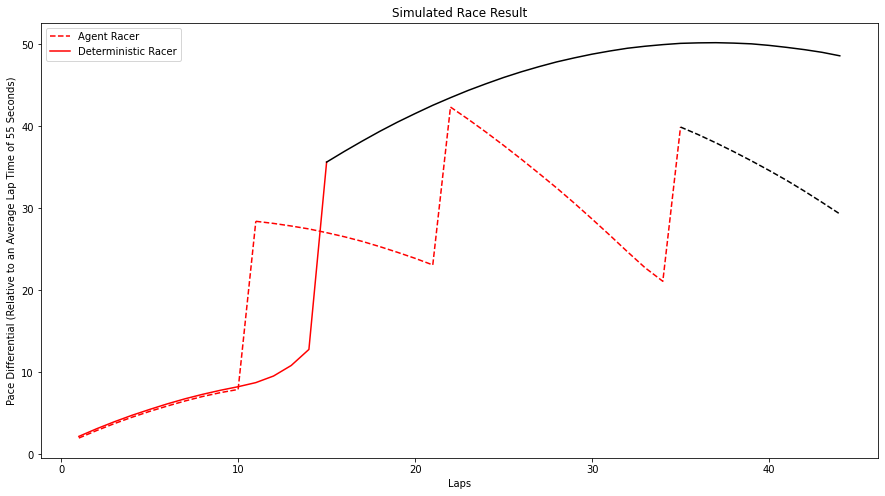

13000 : Episode || Reward:  -55.71 	|| Average Reward:  -55.99 	 epsilon:  0.01
14000 : Episode || Reward:  -56.08 	|| Average Reward:  -55.86 	 epsilon:  0.01


<Figure size 1080x576 with 0 Axes>

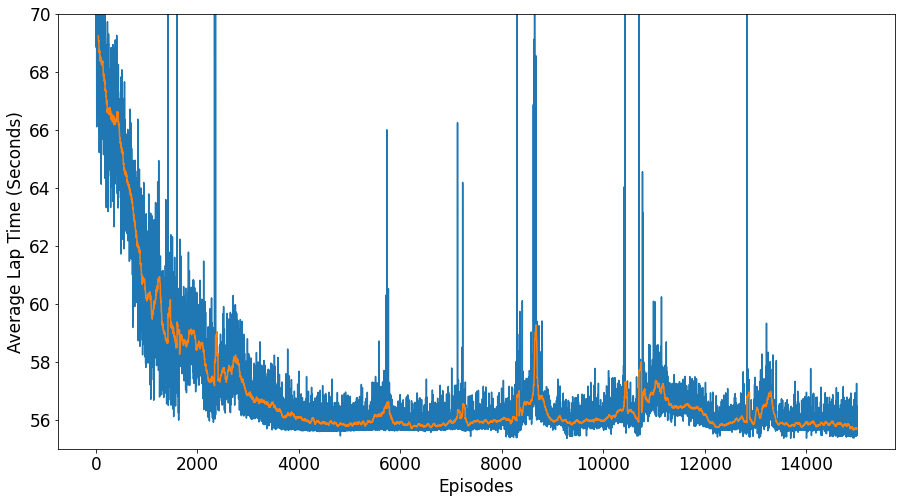

In [7]:
f1_agent = DDQN(env, lr, gamma, epsilon, epsilon_decay,4,8,doubleQ = True,target_update_steps = 50,min_replay_size = 5000)
f1_agent.fill_memory_buffer_f1_interval()
f1_agent.train_f1_interval(training_episodes)
train_rewards_list = pd.DataFrame(f1_agent.rewards_list)
plot_df(-train_rewards_list,"Training","Training","Episodes","Average Lap Time (Seconds)")

The results of training can be observed in the output cell above. The training performance over episodes can be seen in the final graph above, where the agent is able to reduce it's average lap time from around 70 seconds to around 57 seconds in the first 3,000 races, and then spends time trying to further optimize the average lap time to get closer to 55/56 seconds. We can see that there are multiple instances where the optimal policy diverged (for example around race 8,500 and then againa round race 10,500), before coming back down below 56 seconds at the very end of the training. 

The blue spikes in the training performance graph (where we plot an average lap time of 100 seconds for illustrative purposes) represent the cases where our agent was disqualified from the race for not switching tire compounds. It is interesting to note that this does not happen too frequently, and that our agent is able to learn pretty efficiently that using only the soft red tire is not an acceptable strategy. 


To interpret the race simulation graphs, the y-axis is the cumulative gap that the drivers have relative to a 55 second lap, and the x-axis displays the number of laps in the race. Every steep "jump" in the graph represents a pit stop that the agent makes, and the color of the line represent which tire the agent has decided to switch to. For example, our first simulation has our agent driver finishing about 800 seconds behind a fictional car that would have taken exactly 55 seconds for each lap. In this first simulation (after only the first training race), our agent decides to make a pit stop for the hard tire at every lap, and clearly finishes well behind our baseline deterministic racer.

In the simulation after 2,500 episodes, our agent has learned to take more fewer stops, but it is unfortunately still making too many pit stops, as it finishes approximately 80 seconds off of the pace of a 55 second lap. Note that the agent seems to have learned that it needs to use several different compounds in the race to avoid disqualification, as it first makes several pitstops onto red soft tires before making three pitstops to put on hard tires towards the end of the race.

After 5,000 episodes, our agent has found a way to beat the deterministic racer! In a 45 lap simulation race, it makes 3 total pitstops, 2 for the red soft tire and the last one for the black hard tire in order to avoid disqualification. This strategy beats the baseline 1 pitstop strategy by about 15 seconds.


In the rest of the simulation races, the agent's strategy stays about the same, where it usually makes a couple of pitstops on red soft tires before switching to the hard tire at the end of the race. However, knowing that the yellow medium tire is a quicker tire than the hard tire, and that it generally only spends about 10 laps at the end of the race on the hard tire, our agent would have been better off switching to the medium tire at the end rather than the hard tire. As it turns out, when testing our agent after the full 15,000 episodes (in the next cell below), we see that this is precisely the strategy that our agent has adopted for a 45 lap race! 

The trained agent spends about 10 laps on the soft tire (recall that the "life" of the soft tire is only 10 laps) each time before switching to a new one, and then makes the final stint on the yellow medium tire to avoid disqualification. This outperforms our baseline deterministic racer by an impressive 25 seconds. 

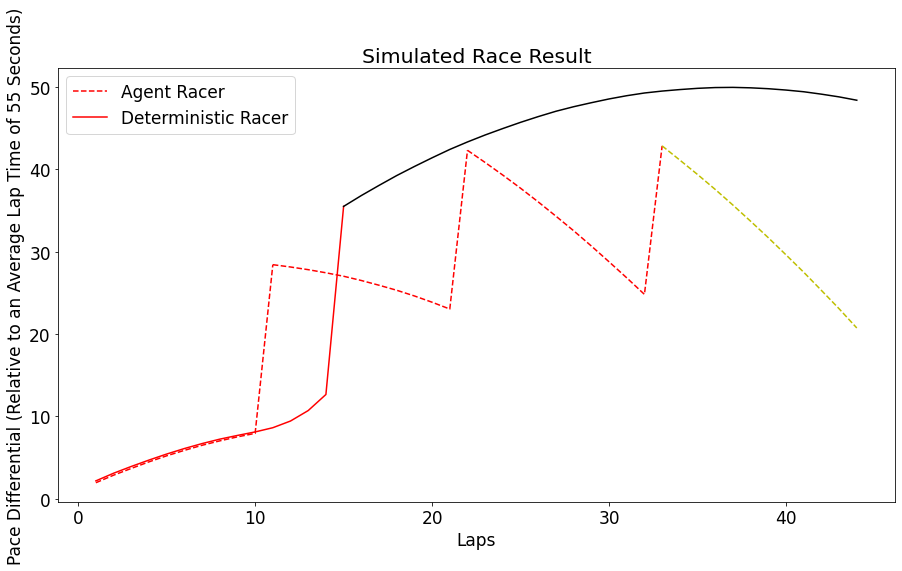

In [8]:
# 45 lap simulation race with fully trained agent
plot_race_baseline(laps = 45,agent = f1_agent)

In order to confirm that our agent has succesfully been able to adopt a successful pitstop strategy irresepctive of the race distance, we run a couple of simulations on varying race distances below. 

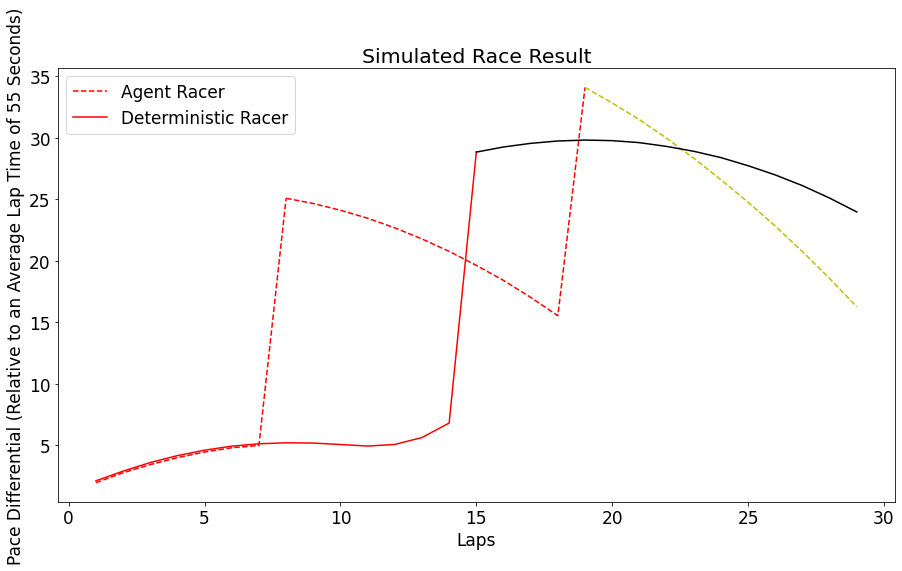

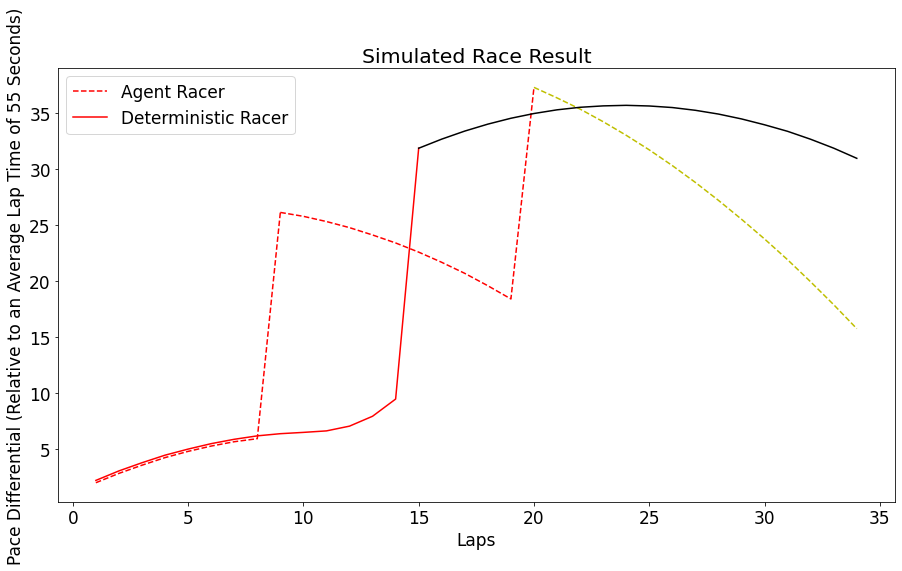

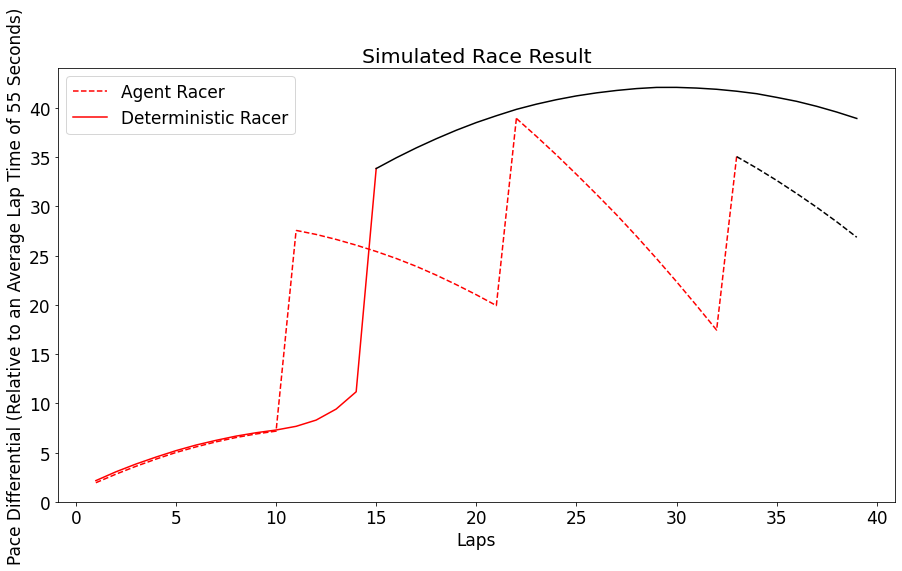

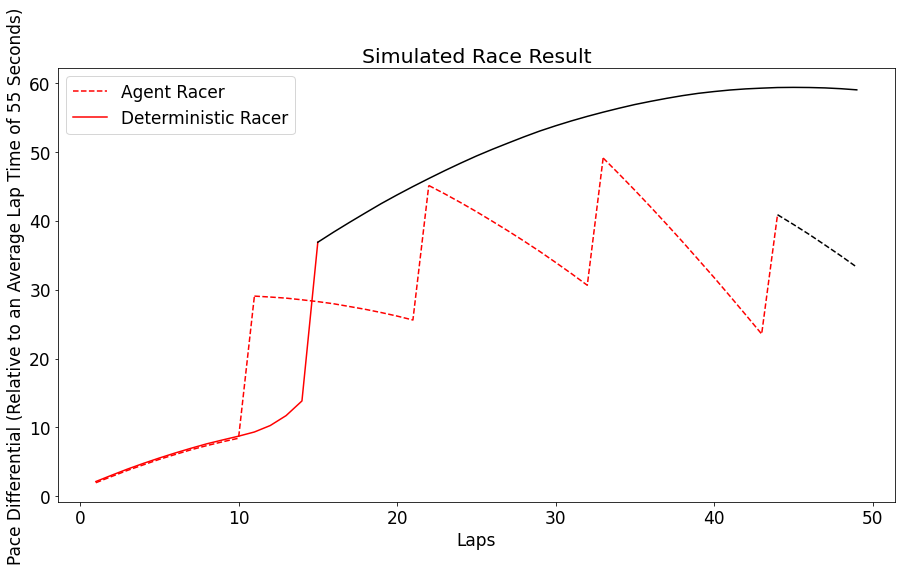

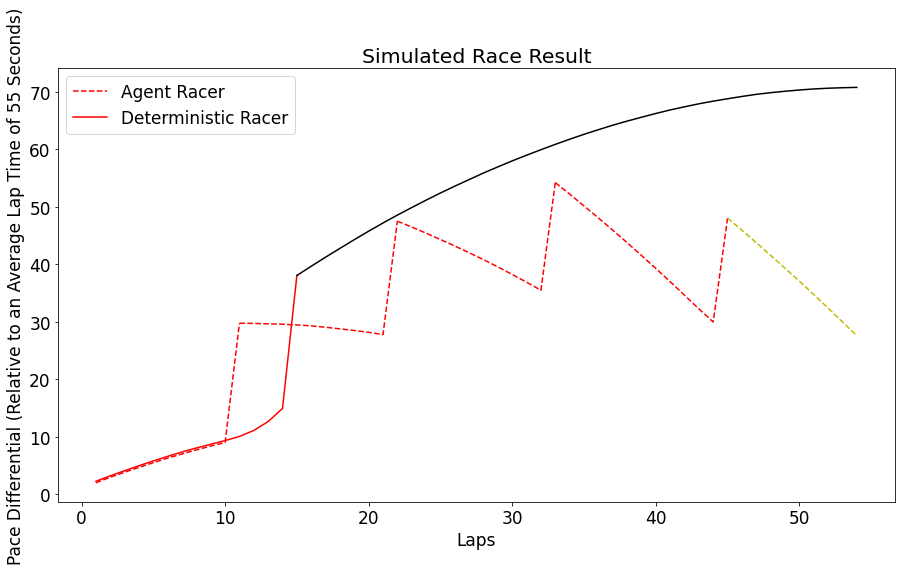

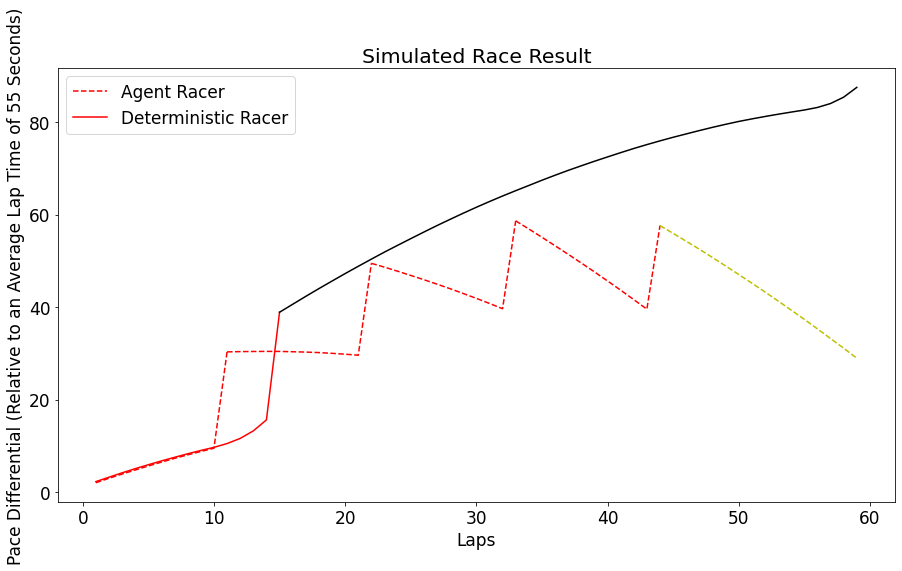

In [9]:
plot_race_baseline(30,agent = f1_agent)
plot_race_baseline(35,agent = f1_agent)
plot_race_baseline(40,agent = f1_agent)
plot_race_baseline(50,agent = f1_agent)
plot_race_baseline(55,agent = f1_agent)
plot_race_baseline(60,agent = f1_agent)


As seen in the simulations above, regardless of the race distance, the policy adopted by our trained agent outperforms the one of our baseline deterministic racer. However, it is interesting to note that there still seems to be room for improvement in our agent's strategy, as for certain race distances (for example the 40 lap and 50 lap races), the trained agent decides to make a final pitstop for slower hard tires rather than for the quicker yellow medium tires. It's possible that increasing the training time would allow our agent to fully learn the optimal strategy for all race distances, but computational restrictions meant that we couldn't train for longer than 12 hours at a time before experiencing disconnects and other issues. 

## Concluding Thoughts

In a recent paper from 2020, DeepMind outlines the potential impact that reinforcement learning can have in the ever growing domain of sports analytics. [3] Although the paper is focused specifically on applying reinforcement learning algorithms in football to evaluate player decision-making, the same impact can surely be had in other sports with complex strategic environments, such as Formula 1. In practice, Formula 1 teams employ huge teams of strategists who run complicated Monte-Carlo based models to decide when to make pitstops in real time during a race. Although a real race environment is orders of magnitude more complex than the environment in which we've trained an agent here, we've demonstrated the capability of reinforcement learning techniques to learn the more basic nuances of Formula 1 strategy. With additional computing power, it would be fascinating to slowly and slowly increase the complexity of the environment, allow for over-taking moves between racers to make for a true multi-agent environment, and evaluate the role that trained RL agents could have in helping shape team strategies for real Formula 1 teams. 

With more time and computational power, it would have been interesting to do a bit more hyper-parameter testing to see which inputs allowed the the quicktest and most stable training. This project was also a great way to learn just how hard it is to apply reinforcement learning algorithms to novel real-world problems in custom environments. RL algorithms are notoriously hard to debug, as the slightest issue either in the environment or in the learning algorithm can easily cause our agent to be unable to learn an effective policy. I look forward to making improvements to the Formula 1 environment we've created to test the limits of what RL agents can and can't be trained to learn.





## References

[1] Hado van Hasselt, Arthur Guez, David Silver: Deep Reinforcement Learning with Double Q-learning. https://arxiv.org/abs/1509.06461

[2] Silver, D., Huang, A., Maddison, C. et al. Mastering the game of Go with deep neural networks and tree search. Nature 529, 484–489 (2016). https://doi.org/10.1038/nature16961

[3] Karl Tuys, Shayegan Omidshafiei, Paul Muller, et al : Game Plan: What AI can do for Football, and What Football can do for AI. https://arxiv.org/abs/2011.09192

[4] Peter Henderson, Riashat Islam, Philip Bachman et al: Deep Reinforcement Learning that Matters. https://arxiv.org/abs/1709.06560

[5] Business Standard, "Lewis Hamilton wins Spanish GP after intense pitstop strategy battle", https://www.business-standard.com/article/sports/lewis-hamilton-wins-spanish-gp-after-intense-pitstop-strategy-battle-121050900737_1.html